In [495]:
import json
import numpy as np
import matplotlib.pyplot as plt
from snsphd import viz
import math
import orjson
Colors, pallet = viz.phd_style(jupyterStyle = True, grid = True, axese_width=0.5, text = 6, svg_mode=True)

from enum import Enum
from dataclasses import dataclass, fields, field, _MISSING_TYPE 

from load_schema import Decode, Result, Event

import matplotlib as mpl
import os

# set the DPI for all figures
mpl.rcParams['figure.dpi'] = 100

from snsphd.layout import bisect

from numba import njit
from snsphd.viz import save_bokeh_dark_json
from snsphd.layout import bisect

from pydantic import BaseModel

from overlap_measure import BiGauss

import networkx as nx

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [461]:
from worker import DecodingResults


# this takes a few seconds
with open("../inter/output.json", "rb") as file:
    dic = orjson.loads(file.read())


    dec = DecodingResults(**dic)


with open("../inter/decode_20GHz26.0.json", "r") as f:
    data = orjson.loads(f.read())
    decode = Decode(**data)

db_values = np.arange(16,50, 2).tolist()
print(db_values)

# need type hints for intellisense to work
def decode_from_folder(folder_path: str, db_values: list[int]) -> list[Decode]:
    decodes = []
    for db in db_values:
        filename = f"decode_20GHz{db}.0.json"
        filepath = os.path.join(folder_path, filename)
        with open(filepath, "r") as f:
            data = orjson.loads(f.read())
            decode = Decode(**data)
            decodes.append(decode)
    return decodes

decodes = decode_from_folder("../inter", db_values)

[16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48]


In [462]:
from load_schema import GMData
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, single_ellipse=False, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    if single_ellipse:
        nsig = 3
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
    else:
        for nsig in np.linspace(0,4, 8):
            ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                                angle=angle, fill=False, edgecolor='black', **kwargs))
        
    
        

def plot_gmm(ax, gm_data: GMData, label=True, data_alpha=0.2, single_ellipse=False, **ellipse_kwargs):

    w_factor = 0.2 / gm_data.weights.max()
    for pos, covar, w in zip(gm_data.means, gm_data.covariances, gm_data.weights):
        draw_ellipse(pos, covar, ax=ax, single_ellipse=single_ellipse, **ellipse_kwargs)

def plot_gmm_single(ax, gm_data: GMData, ellipse_idx = 0, label=True, data_alpha=0.2, single_ellipse=False, **ellipse_kwargs):
    w_factor = 0.2 / gm_data.weights.max()

    draw_ellipse(gm_data.means[ellipse_idx], gm_data.covariances[ellipse_idx], ax=ax, single_ellipse=single_ellipse, **ellipse_kwargs)


shifting means x by -16.324610270071762
shifting means y by 638.5624698528117


C:\Users\Andrew\AppData\Local\Temp\ipykernel_30836\189041254.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


(-500.0, 500.0)

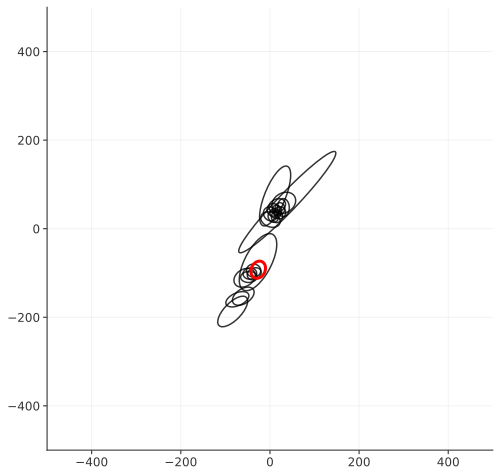

In [528]:
import copy

fig, ax = plt.subplots(1,1,figsize=(8,8))

dbidx = 8

comp_idx = 10

st = copy.deepcopy(decodes[dbidx].gm_data.gm_list[comp_idx])
print(f"shifting means x by { np.average(st.means[:,0], weights=st.weights)}")
print(f"shifting means y by { np.average(st.means[:,1], weights=st.weights)}")


st.means[:,0] = st.means[:,0] - np.average(st.means[:,0], weights=st.weights)
st.means[:,1] = st.means[:,1] - np.average(st.means[:,1], weights=st.weights)



plot_gmm(ax, st, single_ellipse=True, lw=1.5, alpha=0.8)

plot_gmm_single(ax, st, ellipse_idx = 5, single_ellipse=True, lw=3, alpha=1, color='red')



# for pos, w in zip(decodes[dbidx].gm_data.gm_list[comp_idx].means, decodes[dbidx].gm_data.gm_list[comp_idx].weights):
#     print("position: ", pos, "weight: ", w)

ax.set_xlim(-500,500)
ax.set_ylim(-500, 500)


# you will make sub-GMDatas for each distinct photon number
# then, for each even, I guess you test all sub-gms and assign the event a photon number based on most probable. 
# I guess you could arrange the sub-gms in order of most to least probable.

# how is photon number confidence determined?



In [529]:
from overlap_measure import BiGauss
from kl_divergence import kl_mvn

st = copy.deepcopy(decodes[dbidx].gm_data.gm_list[comp_idx])

st.means[:,0] = st.means[:,0] - np.average(st.means[:,0], weights=st.weights)
st.means[:,1] = st.means[:,1] - np.average(st.means[:,1], weights=st.weights)

# loc = decodes[dbidx].gm_data.gm_list[comp_idx]

size = len(st.means)

adj_matrix = np.zeros((size, size), dtype=np.float64)
adj_matrix_kl = np.zeros((size, size), dtype=np.float64)

for i, (pos, cov, w) in enumerate(zip(st.means, st.covariances, st.weights)):
    pos_ = pos/100  # scale down position

    cov_ = cov/10000  # scale down covariance
    w_ = w
    for j, (pos_inner, cov_inner, w_inner) in enumerate(zip(st.means, st.covariances, st.weights)):
        if i == j:
            continue
        pos_inner_ = pos_inner/100  # scale down position
        cov_inner_ = cov_inner/10000  # scale down covariance
        w_inner_ = w_inner


        # bi = BiGauss(pos_, pos_inner_, cov_, cov_inner_, w_, w_inner_, steps=300)
        # try:
        # adj_matrix[i,j] = bi.OLR()[0]

        adj_matrix_kl[i,j] = kl_mvn((pos_inner_, cov_inner_), (pos_, cov_)) + kl_mvn((pos_, cov_), (pos_inner_, cov_inner_)) #+ 

adj_kl_log_distance = (1 - np.log(adj_matrix_kl)) - np.min((1 - np.log(adj_matrix_kl)))




C:\Users\Andrew\AppData\Local\Temp\ipykernel_30836\4127617562.py:35: RuntimeWarning: divide by zero encountered in log
  adj_kl_log_distance = (1 - np.log(adj_matrix_kl)) - np.min((1 - np.log(adj_matrix_kl)))


In [530]:
arr = (40 - adj_matrix_kl)

arr[arr < 0] = 0
arr = arr / np.max(arr)

In [531]:
for q in range(len(adj_kl_log_distance)):
    adj_kl_log_distance[q,q] = 0

adj_kl_log_distance = adj_kl_log_distance / np.max(adj_kl_log_distance)

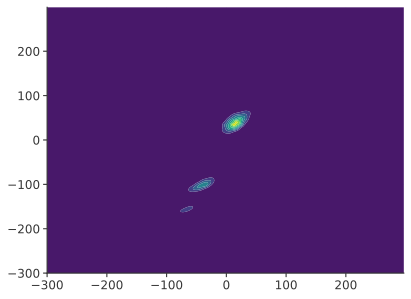

In [532]:
from scipy.stats import multivariate_normal

st = copy.deepcopy(decodes[dbidx].gm_data.gm_list[comp_idx])

st.means[:,0] = st.means[:,0] - np.average(st.means[:,0], weights=st.weights)
st.means[:,1] = st.means[:,1] - np.average(st.means[:,1], weights=st.weights)

def total_multivariate_normal(gm_data: GMData, X):

    gausses = []
    total = 0
    for pos, cov, w in zip(gm_data.means, gm_data.covariances, gm_data.weights):
        gausses.append(multivariate_normal(mean=pos, cov=cov, allow_singular=True))

    for w, mean, gauss in zip(gm_data.weights, gm_data.means, gausses):
        total += w*(gauss.pdf(X)/gauss.pdf(mean))

    return total


x, y = np.mgrid[-300:300:3, -300:300:1]
pos = np.dstack((x, y))
plt.contourf(x, y, total_multivariate_normal(st, pos))

    

In [533]:
# gdm = decodes[dbidx].gm_data.gm_list[comp_idx]
# q = 2
# print(gdm.means[q])
# print(gdm.covariances[q])
# mvn = multivariate_normal(mean=gdm.means[q], cov=gdm.covariances[q], allow_singular=True)
# mvn.pdf([24,589])/mvn.pdf(gdm.means[q])


# G = nx.from_numpy_array(adj_matrix)
# back = nx.to_numpy_array(G)
# # print(G.edges(data=True))

# res = nx.community.louvain_communities(G, resolution=2)
# print(res)


In [534]:
G = nx.from_numpy_array(arr)
# print(G.edges(data=True))
res = nx.community.louvain_communities(G, resolution=.4)

# red = nx.community.k_clique_communities(G, 1)
res

[{2},
 {1, 5, 7, 11, 21, 22, 23},
 {0, 4, 6, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 24},
 {3, 10, 20}]

4


C:\Users\Andrew\AppData\Local\Temp\ipykernel_30836\189041254.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


(-250.0, 250.0)

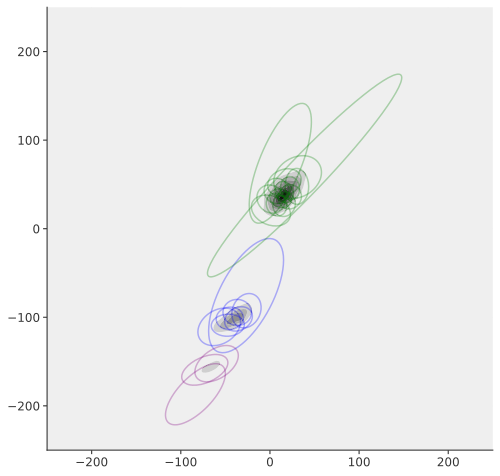

In [538]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

plot_gmm(ax, st, single_ellipse=True, lw=1.5, alpha=0.8)


x, y = np.mgrid[-300:300:3, -300:300:1]
pos = np.dstack((x, y))
ax.contourf(x, y, total_multivariate_normal(st, pos), alpha=1, cmap='gray_r')

colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan', 'magenta']
print(len(res))
cl = colors[:len(res)]
for color, ress in zip(cl, res):
    for item in ress:
        plot_gmm_single(ax, st, ellipse_idx = item, single_ellipse=True, lw=1.5, alpha=0.3, color=color)
        # print(st.weights[item])




ax.set_xlim(-250,250)
ax.set_ylim(-250, 250)



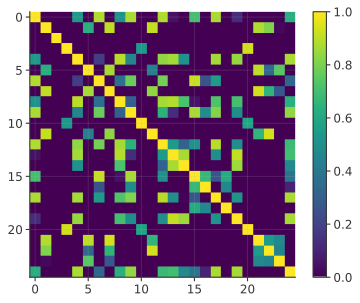

In [539]:
# Assuming adj_matrix is your adjacency matrix
plt.imshow(arr, cmap='viridis', interpolation='nearest', origin='upper')
plt.colorbar()
plt.show()

C:\Users\Andrew\AppData\Local\Temp\ipykernel_30836\496668900.py:5: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(adj_matrix), cmap='viridis', interpolation='nearest', origin='upper')


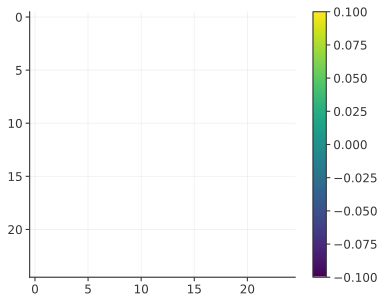

In [540]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Assuming adj_matrix is your adjacency matrix
plt.imshow(np.log(adj_matrix), cmap='viridis', interpolation='nearest', origin='upper')
plt.colorbar()
plt.show()

1.1799831189416368e-76
1.83961383895485e-75
2.8053301658844317e-74
4.184540113867038e-73
6.105453516979151e-72
8.713538668606341e-71
1.2164034311283713e-69
1.6609905062032952e-68
2.2185187511589758e-67
2.898447894063482e-66
3.704028596837512e-65
4.630091829589373e-64
5.661236761514851e-63
6.7707919885846865e-62
7.920891514660343e-61
9.063899859991327e-60
1.0145245766473373e-58
1.1107504188134738e-57
1.1895339432975167e-56
1.2460734211019448e-55
1.276782336902834e-54
1.2796657296546517e-53
1.2545346264239117e-52
1.2030265337045137e-51
1.128428898029735e-50
1.0353319892052343e-49
9.29162141304311e-49
8.156612291598967e-48
7.003813495753423e-47
5.882551879808706e-46
4.832850927868384e-45
3.8837160738953966e-44
3.05279741815511e-43
2.3472261716717725e-42
1.7652992313581506e-41
1.298638174861923e-40
9.344680096221231e-40
6.577292434523397e-39
4.5283116104146066e-38
3.0495228914525027e-37
2.0087871928732933e-36
1.2943222111018093e-35
8.15750440459354e-35
5.02896565891548e-34
3.03253947601212

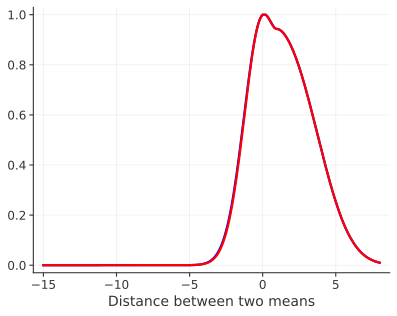

In [110]:
# from overlap_measure import BiGauss
# ms = []

# step = 0.1
# pi1 = 0.5
# OLRs = []
# x = []
# mu1 = [0,0]
# mu2 = [-15,3]
# Sigma1 = [[1,0],[0,1]]
# Sigma2 = [[2.17,1.82], [1.82,2.17]]
# while mu2[0] <= 8.0:
#     pi2 = 1.0-pi1
#     Bi = BiGauss(mu1, mu2, Sigma1, Sigma2, pi1, pi2, steps=50)
#     olr, arr = Bi.OLR()
#     ms.append(arr)
#     OLRs.append(olr)
#     x.append(mu2[0])
#     mu2[0] += step
# plt.plot(x, OLRs, color='blue')


# step = 0.1
# pi1 = 0.5
# OLRs = []
# x = []
# mu1 = [0,0]
# mu2 = [-15,3]
# Sigma1 = [[1,0],[0,1]]
# Sigma2 = [[2.17,1.82], [1.82,2.17]]
# while mu2[0] <= 8.0:
#     pi2 = 1.0-pi1
#     Bi = BiGauss(mu2, mu1, Sigma2, Sigma1, pi2, pi1, steps=50)

#     olr, arr = Bi.OLR()
#     ms.append(arr)
#     OLRs.append(olr)
#     x.append(mu2[0])
#     mu2[0] += step
# plt.plot(x, OLRs, color='red')




# plt.xlabel('Distance between two means')
# plt.show()

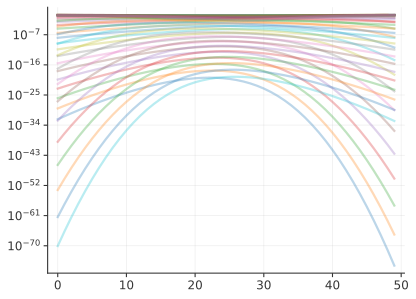

In [30]:
for i, item in enumerate(ms):
    if i % 8 == 0:
        plt.plot(item, alpha=0.3)
    # plt.plot(item, alpha=0.3)
plt.yscale('log')